In [2]:
#!pip3 install imblearn
#!pip3 install opencv-python

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

2023-05-15 12:22:03.298952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. READ-IN DATA TO DF

In [2]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [3]:
df["label"].value_counts()

label
0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

# 2. DELETE 8k RANDOM IMAGES & SHUFFLE

In [4]:
# delte 7802 random images from the category with label 0
df_us = df.drop(df[df["label"] == 0].sample(7702, random_state=1).index)
df_us["label"].value_counts()

label
0    1100
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

In [84]:
# shuffle the dataframe
df_us = df_us.sample(frac=1, random_state=1).reset_index(drop=True)
df_us.head(5)

,image,label
0,ESP_018720_2655_RED-0035.jpg,2
1,ESP_046991_0950_RED-0024.jpg,7
2,ESP_039350_1915_RED-0186.jpg,1
3,ESP_014156_1865_RED-0023.jpg,3
4,ESP_013049_0950_RED-0088.jpg,7


# 3. READ-IN TO PIXELS

In [85]:
def load_images_labels_from_df(df, folder):
    images = []
    labels = []
    for i in range(len(df)):
        img = cv2.imread(folder+"/"+df.iloc[i][0], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(df.iloc[i][1])
    return np.array(images), np.array(labels)

In [86]:
X, y = load_images_labels_from_df(df_us, "map-proj-v3_2")
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
print(X.shape[0])

[0 1 2 3 4 5 6 7] [1100  794  166  267  250   74  298  164]
3113


# 4. NORMALIZE DATA TO 0-1

In [87]:
X_norm = X / 255.0
print(X_norm.min())
print(X_norm.max())

0.0
1.0


# 5. TRAIN-TEST SPLIT

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2179, 227, 227) (934, 227, 227) (2179,) (934,)


In [89]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train, return_counts=True)[1]/y_train.shape[0])

print(np.unique(y_test, return_counts=True))
print(np.unique(y_test, return_counts=True)[1]/y_test.shape[0])

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([774, 539, 115, 176, 183,  52, 222, 118]))
[0.35520881 0.24736117 0.0527765  0.080771   0.08398348 0.02386416
 0.1018816  0.05415328]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([326, 255,  51,  91,  67,  22,  76,  46]))
[0.3490364  0.27301927 0.05460385 0.09743041 0.07173448 0.0235546
 0.08137045 0.04925054]


# 6. IMBALANCE HANDLING

## 6.0 Flatten Images

In [90]:
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(2179, 227, 227)
(2179, 51529)


## 6.1 ADASYN

In [91]:
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train) # type: ignore

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f848bbc63a0>
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/threadpoolctl.py", line 605, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/anaconda/envs/azureml_py38/lib/python3.8/ctypes/__init__.py", line 381, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy.libs/libopenblasp-r0-34a18dc3.3.7.so: cannot open shared object file: No such 

## 6.2 OVERSAMPLING

In [92]:
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=3)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_train) # type: ignore

In [51]:
l1 = pd.DataFrame(X_resampled[np.where(y_resampled == 1)[0]])
print(f"Number of duplicates for the first label after oversampling: {l1.duplicated().sum()}")
all_l = pd.DataFrame(X_resampled)
print(f"Number of duplicates for all labels after oversampling: {all_l.duplicated().sum()}")

Number of duplicates for the first label after oversampling: 235
Number of duplicates for all labels after oversampling: 4013


In [93]:
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
unique_b, counts_b = np.unique(y_resampled, return_counts=True)
print(X_train_adasyn.shape)
print(unique, counts)
print(unique_a, counts_a)
print(unique_b, counts_b)

(6226, 51529)
[0 1 2 3 4 5 6 7] [774 539 115 176 183  52 222 118]
[0 1 2 3 4 5 6 7] [774 824 763 772 789 762 760 782]
[0 1 2 3 4 5 6 7] [774 774 774 774 774 774 774 774]


In [6]:
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227) # type: ignore
y_t_A = y_train_adasyn

X_t_O = X_resampled.reshape(X_resampled.shape[0], 227, 227) # type: ignore
y_t_O = y_resampled

print(f"Shape of training instances generated by ADASYN: \n{X_t_A.shape}, correspoding y: {y_t_A.shape}")
print(f"Shape of training instances generated by RandomOverSampler: \n{X_t_O.shape}, correspoding y: {y_t_O.shape}")

NameError: name 'X_train_adasyn' is not defined

# 7. AUGMENTATION
1. Rotate 90
2. Rotate 180
3. Rotate 270
4. Flip Horizontally
5. Flip Vertically
6. Zoom
7. (Random Brightness)?

In [95]:
def zoom_at(img, zoom=1.0):
    h, w, = [zoom * i for i in img.shape]
    cx, cy = w/2, h/2
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
              int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

def augment_images(images, labels):
    """
    Augments a numpy array of images by rotating them by 90, 180, and 270 degrees, flipping them horizontally and
    vertically, and zooming in on them.
    
    Args:
    - images (numpy.ndarray): A numpy array of shape (N, H, W, C), where N is the number of images, H and W are the
                              height and width of the images, and C is the number of color channels.
                              
    Returns:
    - augmented_images (numpy.ndarray): A numpy array of shape (7N, H, W, C), where the first N images are the
                                         original images and the remaining 6N images are the augmented images.
    """
    # Initialize an empty numpy array to store the augmented images
    augmented_images = np.empty((7*images.shape[0], images.shape[1], images.shape[2]))
    augmented_labels = np.empty((7*images.shape[0]))
    

    # Loop through each image in the array and perform the augmentations
    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]

        # Add the original image to the output array
        augmented_images[(i*7)] = image
        augmented_labels[(i*7)] = label
        
        # Rotate the image by 90 degrees
        rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        augmented_images[(i*7)+1] = rotated_90
        augmented_labels[(i*7)+1] = label
        
        # Rotate the image by 180 degrees
        rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
        augmented_images[(i*7)+2] = rotated_180
        augmented_labels[(i*7)+2] = label
        
        # Rotate the image by 270 degrees
        rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmented_images[(i*7)+3] = rotated_270
        augmented_labels[(i*7)+3] = label
        
        # Flip the image horizontally
        flipped_horizontal = cv2.flip(image, 1)
        augmented_images[(i*7)+4] = flipped_horizontal
        augmented_labels[(i*7)+4] = label
        
        # Flip the image vertically
        flipped_vertical = cv2.flip(image, 0)
        augmented_images[(i*7)+5] = flipped_vertical
        augmented_labels[(i*7)+5] = label
        
        # Zoom in on the image
        zoomed_in = zoom_at(image, 1.2)
        augmented_images[(i*7)+6] = zoomed_in
        augmented_labels[(i*7)+6] = label

        print(f"Image, {i} done")

    return augmented_images, augmented_labels

In [96]:
X_t_A_A, y_t_A_A = augment_images(X_t_A, y_t_A)
X_t_O_A, y_t_O_A = augment_images(X_t_O, y_t_O)
print(f"Shape of original training data for ADASYN: {X_t_A.shape} with corresponding y: {y_t_A.shape}")
print(f"Shape of augmented training data for ADASYN: {X_t_A_A.shape} with corresponding y: {y_t_A_A.shape}")
print(f"Shape of original training data for RandomOverSampler: {X_t_O.shape} with corresponding y: {y_t_O.shape}")
print(f"Shape of augmented training data for RandomOverSampler: {X_t_O_A.shape} with corresponding y: {y_t_O_A.shape}")

Image, 0 done
Image, 1 done
Image, 2 done
Image, 3 done
Image, 4 done
Image, 5 done
Image, 6 done
Image, 7 done
Image, 8 done
Image, 9 done
Image, 10 done
Image, 11 done
Image, 12 done
Image, 13 done
Image, 14 done
Image, 15 done
Image, 16 done
Image, 17 done
Image, 18 done
Image, 19 done
Image, 20 done
Image, 21 done
Image, 22 done
Image, 23 done
Image, 24 done
Image, 25 done
Image, 26 done
Image, 27 done
Image, 28 done
Image, 29 done
Image, 30 done
Image, 31 done
Image, 32 done
Image, 33 done
Image, 34 done
Image, 35 done
Image, 36 done
Image, 37 done
Image, 38 done
Image, 39 done
Image, 40 done
Image, 41 done
Image, 42 done
Image, 43 done
Image, 44 done
Image, 45 done
Image, 46 done
Image, 47 done
Image, 48 done
Image, 49 done
Image, 50 done
Image, 51 done
Image, 52 done
Image, 53 done
Image, 54 done
Image, 55 done
Image, 56 done
Image, 57 done
Image, 58 done
Image, 59 done
Image, 60 done
Image, 61 done
Image, 62 done
Image, 63 done
Image, 64 done
Image, 65 done
Image, 66 done
Image

In [97]:
aug_names = ["Original", "Rotate90", "Rotate180", "Rotate270", "Flip Horizontal", "Flip Vertical", "Zoom"]
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

# function that generates 10 random integers from numpy array that are divisible by 7
def generate_random_integers(X, n):
    random_integers = []
    while len(random_integers) < n:
        integer = np.random.randint(0, len(X))
        if integer % 7 == 0:
            random_integers.append(integer)
    return random_integers

# create function that takes 10 random images from the augmented training data and plots them
def plot_augmented_images(X, y, aug_names, class_names, num_images):
    indices = generate_random_integers(X, num_images)
    fig, axes = plt.subplots(len(indices), 7, figsize=(15, 15))
    c = 0
    for i in indices:
        for j in range(7):
            axes[c, j].imshow(X[i+j], cmap="gray")
            axes[c, j].set_xticks([])
            axes[c, j].set_yticks([])
            
            axes[c, j].set_xlabel(aug_names[j] + " " + str(int(i+j)))
            if j == 0:
                axes[c, j].set_ylabel(class_names[int(y[i+j])])
        c += 1
    plt.show()

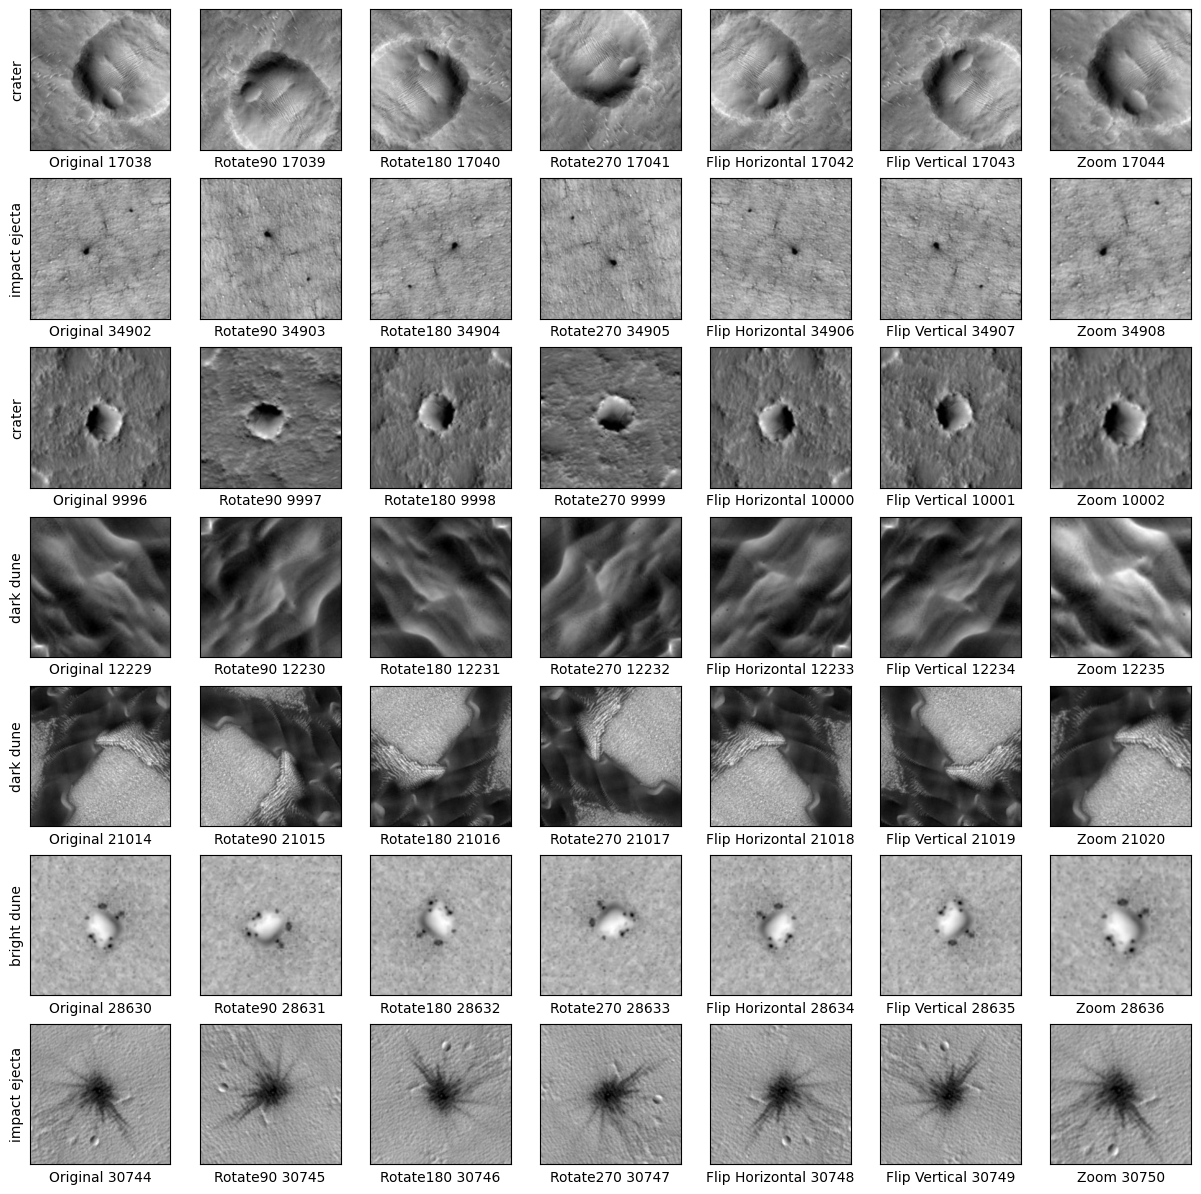

In [98]:
plot_augmented_images(X_t_A_A, y_t_A_A, aug_names, class_names, 7)

In [99]:
def safe_csv(augmented_images, augmented_labels, input_filename, num_images):
    indices = generate_random_integers(X, num_images)
    
    # filter out the images and labels that are not in the indices
    augmented_images = augmented_images[indices]
    augmented_labels = augmented_labels[indices]
    
    # Reshape the augmented images and convert to a DataFrame
    images_2d = augmented_images.reshape(augmented_images.shape[0], -1)
    images_df = pd.DataFrame(images_2d)
    images_df['label'] = augmented_labels
    print(images_df.head())

    # Save the DataFrame as a CSV file with the original filename
    output_filename = input_filename + '_augmented.csv'
    images_df.to_csv(output_filename, index=False)

In [100]:
safe_csv(X_t_A_A, y_t_A_A, "ADAYN_train", 1000)

          0         1         2         3         4         5         6  \
0  0.254902  0.250980  0.247059  0.247059  0.247059  0.247059  0.250980   
1  0.592157  0.592157  0.592157  0.596078  0.600000  0.600000  0.596078   
2  0.572549  0.564706  0.552941  0.537255  0.517647  0.501961  0.494118   
3  0.670588  0.662745  0.635294  0.627451  0.682353  0.678431  0.631373   
4  0.541176  0.572549  0.556863  0.552941  0.631373  0.635294  0.596078   

          7         8         9  ...     51520     51521     51522     51523  \
0  0.254902  0.262745  0.274510  ...  0.227451  0.223529  0.223529  0.223529   
1  0.592157  0.596078  0.592157  ...  0.603922  0.611765  0.619608  0.623529   
2  0.490196  0.509804  0.533333  ...  0.556863  0.568627  0.568627  0.564706   
3  0.654902  0.560784  0.494118  ...  0.000000  0.000000  0.000000  0.000000   
4  0.576471  0.584314  0.635294  ...  0.584314  0.596078  0.576471  0.521569   

      51524     51525     51526     51527     51528  label  
0  0.22

In [102]:
safe_csv(X_t_O_A, y_t_O_A, "OVER_train", 1000)

          0         1         2         3         4         5         6  \
0  0.545098  0.556863  0.572549  0.568627  0.552941  0.564706  0.568627   
1  0.466667  0.462745  0.454902  0.450980  0.454902  0.470588  0.486275   
2  0.525490  0.431373  0.494118  0.513725  0.474510  0.407843  0.513725   
3  0.243137  0.227451  0.184314  0.145098  0.121569  0.113725  0.117647   
4  0.545098  0.545098  0.541176  0.537255  0.537255  0.541176  0.545098   

          7         8         9  ...     51520     51521     51522     51523  \
0  0.552941  0.560784  0.564706  ...  0.552941  0.541176  0.533333  0.545098   
1  0.494118  0.517647  0.541176  ...  0.521569  0.533333  0.537255  0.533333   
2  0.486275  0.517647  0.505882  ...  0.592157  0.556863  0.588235  0.470588   
3  0.125490  0.137255  0.152941  ...  0.231373  0.227451  0.215686  0.207843   
4  0.549020  0.552941  0.552941  ...  0.580392  0.580392  0.580392  0.576471   

      51524     51525     51526     51527     51528  label  
0  0.55

# ResNet